## Imports

In [1]:
import os

%load_ext autoreload
%autoreload 2
# %load_ext nb_black

In [2]:
!pip install timm

In [3]:
import timm

timm.__version__

'0.6.12'

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [11]:
import pandas as pd
import numpy as np

import time
import random
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import cv2
import PIL.Image
import albumentations

import gc

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline

import math
import glob

from warnings import filterwarnings

filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
albumentations.__version__

'1.3.0'

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Setting all seeds to be {seed}.")


seed_everything(1337)

Setting all seeds to be 1337.


## Configuration

In [16]:
image_size = 256
batch_size = 256
n_worker = 0
init_lr = 3e-4  # / 3  # 3e-5
n_epochs = 2
fold_id = 1
debug = False  # set this to False to train in full
kernel_type = "resnet18_first_try"
model_dir = "weights/"
train_data_dir = "./animals/animals/train/"
test_data_dir = "./animals/animals/test/"

!mkdir $model_dir

ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


In [17]:
os.listdir(train_data_dir)

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [18]:
all_files = list()
all_labels = list()
for label in os.listdir(train_data_dir):
    files = os.listdir(train_data_dir + label)
    files = [os.path.join(train_data_dir, label, f) for f in files]
    labels = [label] * len(files)
    all_files.extend(files)
    all_labels.extend(labels)

df_train = pd.DataFrame()
df_train["path"] = all_files
df_train["label"] = all_labels

df_train = df_train.sample(frac=1, random_state=1337)
df_train = df_train.reset_index(drop=True)
df_train.head()

,path,label
0,./animals/animals/train/dog\mjzimpxbcgnsukbsbf...,dog
1,./animals/animals/train/elephant\vyixyxkuwogak...,elephant
2,./animals/animals/train/butterfly\laztnjisfvir...,butterfly
3,./animals/animals/train/horse\oxjxbpkcdtaahfyp...,horse
4,./animals/animals/train/cow\uhqzadrisyhsdvlxie...,cow


In [19]:
test_files = [os.path.join(test_data_dir, f) for f in os.listdir(test_data_dir)]

df_test = pd.DataFrame()
df_test["path"] = test_files
df_test.head()

,path
0,./animals/animals/test/aaaegzyvdinxeykckmsu.jpg
1,./animals/animals/test/aaaetljquphwtxveopla.jpg
2,./animals/animals/test/aabhuruvegisgvnakivm.jpg
3,./animals/animals/test/aacnzglbgwgdyghicntc.jpg
4,./animals/animals/test/aadilhzngwjjxgcttuaf.jpg


In [20]:
len(df_train), len(df_test)

(10468, 15711)

In [21]:
df_train["label"].nunique()

10

## Make Folds

In [22]:
kf = StratifiedKFold(n_splits=5)
df_train["fold"] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train, df_train["label"])):
    df_train.loc[valid_idx, "fold"] = fold

In [23]:
df_train.head()

,path,label,fold
0,./animals/animals/train/dog\mjzimpxbcgnsukbsbf...,dog,0
1,./animals/animals/train/elephant\vyixyxkuwogak...,elephant,0
2,./animals/animals/train/butterfly\laztnjisfvir...,butterfly,0
3,./animals/animals/train/horse\oxjxbpkcdtaahfyp...,horse,0
4,./animals/animals/train/cow\uhqzadrisyhsdvlxie...,cow,0


In [24]:
le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["label"])

## Transforms

In [25]:
transforms_train = albumentations.Compose(
    [
        albumentations.Resize(image_size, image_size),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(
            p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)
        ),
        albumentations.HueSaturationValue(
            p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2
        ),
        albumentations.ShiftScaleRotate(
            p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20
        ),
        albumentations.CoarseDropout(p=0.5),
        albumentations.Normalize(),
    ]
)

transforms_valid = albumentations.Compose(
    [albumentations.Resize(image_size, image_size), albumentations.Normalize()]
)

## Dataset

In [26]:
class AnimalDataset(Dataset):
    def __init__(self, df, mode, transform=None):

        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row["path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=img)
            img = res["image"]

        img = img.astype(np.float32)
        img = img.transpose(2, 0, 1)

        if self.mode == "test":
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row["label"]).float()

5


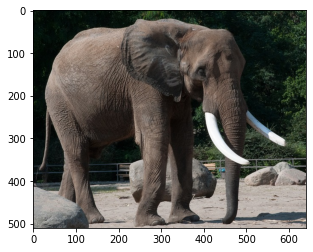

4


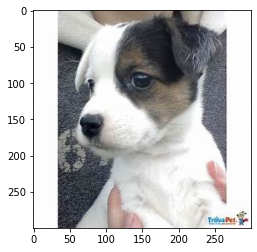

8


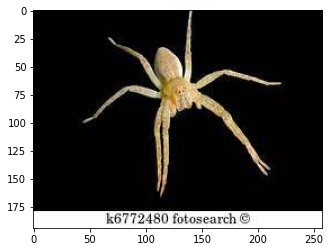

In [27]:
idx_to_show = [1, 100, 1000]
for idx in idx_to_show:
    label = df_train['label'][idx]
    print(label)
    img = cv2.imread(df_train['path'][idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

## Model

In [28]:
mod = "resnet18"
backbone = timm.create_model(mod, pretrained=False, num_classes=0)
o = backbone(torch.randn(2, 3, image_size, image_size))

del backbone
torch.cuda.empty_cache()
gc.collect()

in_features = o.shape[1]
in_features

512

In [29]:
class AnimalNet(nn.Module):
    def __init__(
        self,
        dropout_p=0.5,
        num_labels=10,
        backbone="resnet18",
        pretrained=True,
        in_features=None,
    ):
        super(AnimalNet, self).__init__()
        self.dropout_p = dropout_p
        self.num_labels = num_labels

        self.backbone = timm.create_model(
            backbone, pretrained=pretrained, num_classes=0
        )

        # Freeze all backbone's layers (try to experiment with this)
        for param in self.backbone.parameters():
            param.requires_grad = False

        if in_features is None:
            self.in_features = self.backbone.classifier.in_features
        else:
            self.in_features = in_features

        self.dropout = nn.Dropout(p=self.dropout_p, inplace=True)
        self.fc1 = nn.Linear(self.in_features, self.num_labels)

    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)
        #         features = features.view(features.size(0), -1)
        features = self.fc1(features)
        return features

In [30]:
df_train_this = df_train[df_train["fold"] != fold_id]
df_valid_this = df_train[df_train["fold"] == fold_id]

In [31]:
dataset_train = AnimalDataset(df_train_this, "train", transform=transforms_train)
dataset_valid = AnimalDataset(df_valid_this, "valid", transform=transforms_valid)
dataset_test = AnimalDataset(df_test, "test", transform=transforms_valid)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_worker,
    drop_last=False,
)
valid_loader = torch.utils.data.DataLoader(
    dataset_valid, batch_size=batch_size, shuffle=False, num_workers=n_worker
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=n_worker
)

In [32]:
model = AnimalNet(
    num_labels=df_train["label"].nunique(),
    backbone=mod,
    in_features=in_features,
)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Лёша/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


AnimalNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

## Utils

In [34]:
def train_func(model, train_loader):
    model.train()
    bar = tqdm(train_loader)

    losses_list = list()
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device).long()

        if debug and batch_idx == 100:
            print("Debug Mode. Only train on first 100 batches.")
            break

        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses_list.append(loss.item())

        bar.set_description(f"loss_train: {loss.item():.5f}")

    loss_train = np.mean(losses_list)
    print("loss_train:", loss_train)
    return loss_train


def valid_func(model, valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    targets_list = list()
    losses_list = list()
    preds_list = list()

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device).long()

            logits = model(images)

            preds_list += [torch.argmax(logits, 1).detach().cpu()]
            targets_list += [targets.detach().cpu()]

            loss = criterion(logits, targets)
            losses_list.append(loss.item())

            bar.set_description(f"loss_valid: {loss.item():.5f}")

    preds_list = torch.cat(preds_list).cpu().numpy()
    targets_list = torch.cat(targets_list).cpu().numpy()
    accuracy = (preds_list == targets_list).mean()

    loss_valid = np.mean(losses_list)
    return loss_valid, accuracy


def test_func(model, test_loader):
    model.eval()
    bar = tqdm(test_loader)

    preds_list = list()

    with torch.no_grad():
        for batch_idx, images in enumerate(bar):

            images = images.to(device)
            logits = model(images)
            preds_list += [torch.argmax(logits, 1).detach().cpu()]
    preds_list = torch.cat(preds_list).cpu().numpy()
    return preds_list

## Train

In [35]:
%%time

for epoch in tqdm(range(n_epochs), desc="epochs"):

    print(f"Epoch {epoch + 1} started")
    torch.cuda.empty_cache()

    print("LR:", optimizer.state_dict()["param_groups"][0]["lr"])
    loss_train = train_func(model, train_loader)
    scheduler.step()
    
    loss_valid, accuracy = valid_func(model, valid_loader)
    print('valid accuracy:', accuracy)
    
    torch.save(
        model.state_dict(),
        f"{model_dir}{kernel_type}_fold{fold_id}_epoch{epoch + 1}.pth",
    )

    print("Checkpoint saved!")
    print()
    print("*" * 90)
    print()

del model
torch.cuda.empty_cache()
gc.collect()

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 started
LR: 0.0003


  0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
model = AnimalNet(
    num_labels=df_train["label"].nunique(),
    backbone=mod,
    in_features=in_features,
)

model.load_state_dict(
    torch.load(
        f"{model_dir}{kernel_type}_fold{fold_id}_epoch{epoch + 1}.pth",
    )
)

model.to(device)

AnimalNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [29]:
%%time

preds = test_func(model, test_loader)

  0%|          | 0/62 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 9.79 s, total: 1min 10s
Wall time: 1min 58s


In [30]:
test_files = os.listdir(test_data_dir)

df_preds = pd.DataFrame()
df_preds["path"] = test_files
df_preds["label"] = preds
df_preds["label"] = le.inverse_transform(df_preds["label"])
df_preds.head()

,path,label
0,bmimftuxqdwpjexjpmtt.jpg,horse
1,gittosxmvjvltzyevrji.jpg,dog
2,rozuhiughubdrgnlhldi.jpg,spider
3,ezltxoovfnxmrquojdvm.jpg,dog
4,rpxerbmbyatglwszwlyd.jpg,spider


In [31]:
df_preds.to_csv("sample_submission.csv", index=False)